## 0.导入所需库

In [17]:
# 导入所需库
import pandas as pd
import jieba
from collections import Counter
import jieba.analyse
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, CoherenceModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import warnings
warnings.filterwarnings('ignore')

## 1.数据预处理：使用停用词表分词

In [18]:
# 加载数据
if not os.path.exists('/Users/elsa/Desktop/工作流/0617/论文学习/articles.csv'):
    raise FileNotFoundError("请确保articles.csv文件存在，并包含title和abstract列")

df = pd.read_csv('/Users/elsa/Desktop/工作流/0617/论文学习/articles.csv', encoding='utf-8-sig')
print(f"数据加载完成，共{len(df)}篇论文")

# 加载自定义词典（优先加载基础词典）
if os.path.exists('/Users/elsa/Desktop/工作流/0617/论文学习/核心规划术语_AI.txt'):
    jieba.load_userdict('/Users/elsa/Desktop/工作流/0617/论文学习/核心规划术语_AI.txt')
    print("已加载基础自定义词典")
else:
    print("未找到基础词典，将使用默认词典")

# 加载停用词表（修正路径不一致问题）
stopwords_path = '/Users/elsa/Desktop/工作流/0617/论文学习/哈工大停用词表_AI.txt'
if os.path.exists(stopwords_path):
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f]
    print(f"已加载停用词表，共{len(stopwords)}个停用词")
else:
    stopwords = []
    print("未找到停用词表，将不使用停用词")

# 动态词典扩展函数（优化版）
def dynamic_dict_update(text_series, min_freq=5):
    """从文本序列动态提取新词并添加词频权重"""
    all_text = ' '.join(text_series.astype(str).tolist())
    word_counts = Counter(jieba.lcut(all_text))
    
    # 过滤条件：非停用词、长度>1、出现频率达标
    new_terms = [
        (w, c) for w, c in word_counts.items() 
        if w not in stopwords and len(w) > 1 and c >= min_freq
    ]
    
    # 按词频降序添加（高频词优先）
    for term, freq in sorted(new_terms, key=lambda x: x[1], reverse=True):
        jieba.add_word(term, freq=freq*10)  # 动态设置词频权重
    
    print(f"动态添加{len(new_terms)}个新词（最高频词：'{new_terms[0][0]}'x{new_terms[0][1]}）")

# 预处理函数（整合动态扩展）
def chinese_preprocess(text):
    """中文文本预处理（含动态词典更新）"""
    if pd.isna(text):
        return ''
    
    # 动态处理当前文本中的潜在新词
    temp_terms = [w for w in jieba.lcut(text) 
                 if len(w) > 2 and w not in stopwords]
    for term in set(temp_terms):  # 去重
        jieba.suggest_freq(term, tune=True)
    
    # 正式分词处理
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords and len(w) > 1]
    return ' '.join(words)

# 执行流程（关键步骤）
print("\n【预处理流程开始】")
# 步骤1：初始动态词典扩展（基于全量数据）
dynamic_dict_update(df['title'] + ' ' + df['abstract'])

# 步骤2：应用预处理
df['processed_text'] = (
    df['title'].fillna('') + ' ' + df['abstract'].fillna('')
).apply(chinese_preprocess)

# 结果验证
print("\n预处理完成，示例结果：")
print(df['processed_text'].iloc[0][:200] + "...")  # 显示前200字符

# 保存结果
output_path = '/Users/elsa/Desktop/工作流/0617/论文学习/processed_papers.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n结果已保存至：{output_path}")


数据加载完成，共622篇论文
已加载基础自定义词典
已加载停用词表，共829个停用词

【预处理流程开始】
动态添加1861个新词（最高频词：'智慧'x602）

预处理完成，示例结果：
智慧 城市 背景 城市规划 设计 分析 智慧 城市 建设 现代 城市 发展 重要 趋势 核心 目标 利用 先进 信息技术 优化 城市 管理 提高 资源 利用效率 改善 居民 生活 质量 背景 城市规划 设计 需要 传统模式 数据 驱动 方向 转型 适应 智慧 城市 发展 需求 本文 分析 智慧 城市 城市规划 内涵 明确 城市规划 设计 智慧 城市 建设 作用 探讨 智慧 城市 背景 城市规划 设...

结果已保存至：/Users/elsa/Desktop/工作流/0617/论文学习/processed_papers.csv


## 3.特征工程

In [19]:
# %%
# 将文本转换为词列表
texts = [text.split() for text in df['processed_text']]

# 创建词典
dictionary = Dictionary(texts)
print(f"原始词典大小: {len(dictionary)}")

# 过滤极端值
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"过滤后词典大小: {len(dictionary)}")

# 创建词袋
corpus = [dictionary.doc2bow(text) for text in texts]
print(f"词袋模型创建完成，共{len(corpus)}篇文档")

# %%
# TF-IDF加权
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
print("TF-IDF加权完成")

原始词典大小: 7259
过滤后词典大小: 1392
词袋模型创建完成，共622篇文档
TF-IDF加权完成


## 4.LDA主题建模

正在训练3个主题的模型...
完成3个主题模型: 一致性=0.452, 困惑度=-7.650
正在训练4个主题的模型...
完成4个主题模型: 一致性=0.408, 困惑度=-8.112
正在训练5个主题的模型...
完成5个主题模型: 一致性=0.476, 困惑度=-7.926
正在训练6个主题的模型...
完成6个主题模型: 一致性=0.419, 困惑度=-8.550
正在训练7个主题的模型...
完成7个主题模型: 一致性=0.408, 困惑度=-8.882
正在训练8个主题的模型...
完成8个主题模型: 一致性=0.453, 困惑度=-8.707
正在训练9个主题的模型...
完成9个主题模型: 一致性=0.424, 困惑度=-9.230


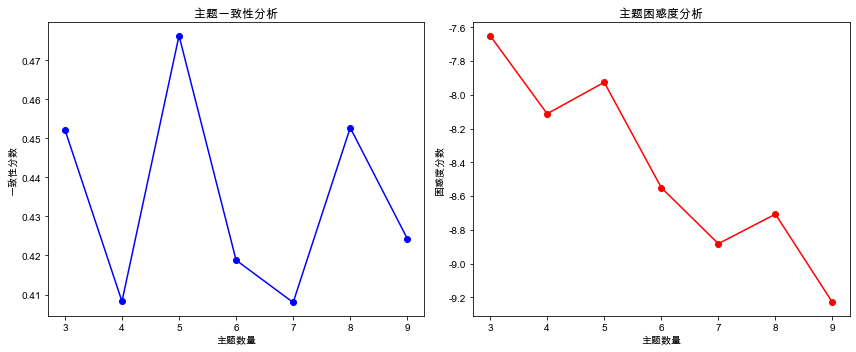

In [20]:
# %%
# 定义主题数范围
num_topics_range = range(3, 10)
models = {}
coherence_scores = []
perplexity_scores = []

# %%
# 训练不同主题数的LDA模型
for num_topics in num_topics_range:
    print(f"正在训练{num_topics}个主题的模型...")
    lda = LdaModel(
        corpus=corpus_tfidf,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto'
    )
    models[num_topics] = lda
    
    # 计算一致性分数
    coherence = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    ).get_coherence()
    coherence_scores.append(coherence)
    
    # 计算困惑度
    perplexity = lda.log_perplexity(corpus_tfidf)
    perplexity_scores.append(perplexity)
    
    print(f"完成{num_topics}个主题模型: 一致性={coherence:.3f}, 困惑度={perplexity:.3f}")

# %%
# 绘制评估曲线
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Heiti SC', 'PingFang SC', 'STHeiti', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_scores, 'b-o')
plt.xlabel('主题数量')
plt.ylabel('一致性分数')
plt.title('主题一致性分析')

plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_scores, 'r-o')
plt.xlabel('主题数量')
plt.ylabel('困惑度分数')
plt.title('主题困惑度分析')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300)
plt.show()


## 5.模型可视化与分析

In [28]:
# 选择最佳主题数（这里假设为6）
best_num_topics = 8
best_lda = models[best_num_topics]

# 准备可视化数据
vis_data = pyLDAvis.gensim_models.prepare(best_lda, corpus, dictionary)

# 保存可视化结果
pyLDAvis.save_html(vis_data, 'ai_urban_planning_lda.html')
print("LDA可视化已保存为ai_urban_planning_lda.html")

# %%
# 提取主题关键词
topics = best_lda.show_topics(num_topics=best_num_topics, num_words=10, formatted=False)

print("="*50)
print(f"AI+城市规划论文主题分析结果（共{best_num_topics}个主题）")
print("="*50)

for topic_id, words in topics:
    print(f"\n主题 {topic_id}:")
    print(", ".join([f"{word[0]}({word[1]:.3f})" for word in words]))

# %%
# 文档-主题分布分析
doc_topics = [best_lda.get_document_topics(doc) for doc in corpus]

# 转换为DataFrame
topic_dist_df = pd.DataFrame()
for i, doc in enumerate(doc_topics):
    for topic, prob in doc:
        topic_dist_df.loc[i, f'Topic_{topic}'] = prob

# 添加原始文本
topic_dist_df['title'] = df['title']
topic_dist_df['abstract'] = df['abstract']
topic_dist_df['processed_text'] = df['processed_text']

# 保存结果
topic_dist_df.to_csv('document_topic_distribution.csv', index=False, encoding='utf-8-sig')




LDA可视化已保存为ai_urban_planning_lda.html
AI+城市规划论文主题分析结果（共8个主题）

主题 0:
国土(0.011), 空间规划(0.011), 智慧(0.006), 地形(0.006), 规划(0.005), 测量(0.005), 12(0.005), 测绘(0.004), 配电网(0.004), 20(0.004)

主题 1:
电网(0.010), 意象(0.008), 智慧(0.006), 风险(0.005), 中国(0.005), 规划(0.005), 城市规划(0.005), 媒体(0.005), 虚拟(0.005), 艺术(0.004)

主题 2:
街道(0.015), 2000(0.005), 教学(0.005), 交通运输(0.005), 品质(0.004), 国家(0.004), 课题(0.004), 课程(0.004), 会议(0.003), 印发(0.003)

主题 3:
三维(0.030), 系统(0.018), 决策(0.016), 辅助(0.016), GIS(0.016), 规划(0.008), 城市规划(0.008), 电网(0.006), 管理(0.006), 二维(0.005)

主题 4:
通信(0.005), 5G(0.004), 形象(0.003), 人机(0.002), 自然(0.002), 可靠(0.002), 互联网(0.002), 深刻(0.002), 众多(0.002), 空间规划(0.002)

主题 5:
新一代(0.005), 智慧(0.005), 业务(0.004), 边界(0.004), 带来(0.004), 区块(0.004), 生命(0.004), 竞争(0.004), 想象(0.003), 适合(0.003)

主题 6:
智慧(0.011), 城市规划(0.008), 空间(0.008), 人工智能(0.008), 技术(0.007), 设计(0.007), 规划(0.006), 应用(0.006), 数字(0.006), 智能(0.005)

主题 7:
街区(0.007), 风貌(0.007), 建筑(0.006), 生成(0.005), 规划(0.005), 感知(0.005), 学习(0.004), 意象(0.004), 机器(0.004), 设计

## 6.结果解读与应用

In [29]:
# %%
# 分析每个主题的代表性论文
dominant_topics = topic_dist_df.drop(['title', 'abstract', 'processed_text'], axis=1).idxmax(axis=1)

# 统计主题分布
topic_distribution = dominant_topics.value_counts().sort_index()
print("\n主题分布统计:")
print(topic_distribution)

# %%
# 为每个主题找出最具代表性的3篇论文
print("\n各主题代表性论文:")
for topic in range(best_num_topics):
    print(f"\n主题 {topic} 的代表性论文:")
    topic_docs = topic_dist_df.nlargest(3, f'Topic_{topic}')
    for idx, row in topic_docs.iterrows():
        print(f"\n标题: {row['title']}")
        print(f"主题概率: {row[f'Topic_{topic}']:.3f}")
        print(f"摘要: {row['abstract'][:100]}...")

# %% [markdown]


主题分布统计:
Topic_0      4
Topic_1      3
Topic_2      2
Topic_3     26
Topic_5      1
Topic_6    584
Topic_7      2
dtype: int64

各主题代表性论文:

主题 0 的代表性论文:

标题: nan
主题概率: 0.802
摘要: 2012-04-27...

标题: 杨静
主题概率: 0.733
摘要: 2016-12-01...

标题: nan
主题概率: 0.732
摘要: 2005-04-28...

主题 1 的代表性论文:

标题: “新时代 新生活——第三届中国设计大展及公共艺术专题展”在深圳举办
主题概率: 0.763
摘要: <正>2019年1月11日,由中华人民共和国文化和旅游部、广东省人民政府和深圳市人民政府主办,文化和旅游部艺术司、广东省文化和旅游厅、中共深圳市委宣传部、深圳市文体旅游局承办,执行单位为深圳市关山月美...

标题: 城市规划准则与当代中国城市规划
主题概率: 0.576


TypeError: 'float' object is not subscriptable

## 7.保存与导出

In [30]:
# %%
# 保存模型
best_lda.save('ai_urban_planning_lda.model')
dictionary.save('ai_urban_planning_dict.dict')
print("模型已保存为ai_urban_planning_lda.model和ai_urban_planning_dict.dict")

模型已保存为ai_urban_planning_lda.model和ai_urban_planning_dict.dict
